## Fitting chickpea hydration data to the Peleg equation



S. Singleton ssinglet@coe.edu

Data are taken from &ldquo;Can We Make Stew With These Beans Handbook&rdquo; (2016) POGIL-PCL experiment. The handbook has tables of representative student data for each TATD section:

TATD 1: chickpea-hbdata1.csv; 0M, 2M, 3M NaCl times/masses in long format

TATD 2: chickpea-hbdata2.csv; 1M, 3M. There seems to be conflicting labels in the sample data.  Results are labeled &ldquo;1M NaCl&rdquo; and k\_1, k\_2 reported. However, the column label for the data below these results are labeled &ldquo;Water uptake pure water normalized&rdquo;. The values for k1 and k2 seem to be closer to the 0M (pure water) data in TATD1, so the data column label is probably correct.



## Python Environment



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit

## Import handbook data Part 1



Run this cell if loading data from local disk.



In [1]:
fn = "chickpea-hbdata1.csv"
data = np.genfromtxt(fn, skip_header=2, delimiter=",")

Uncomment and run the next two cells if using Colab.  Otherwise skip these two cells.



In [1]:
# run this cell only if using colab
#from google.colab import files
#import io
#fn = "chickpea-hbdata1.csv"
#ul = files.upload()

In [1]:
# run this cell only if using colab
#data = np.genfromtxt(io.BytesIO(ul[fn]), skip_header=2, delimiter=",")

## Parse and plot arrays



In [1]:
# subset the data by molarity, M
# and keep the last two columns (time, mass)
M0 = data[data[:,0] == 0][:,1:]
M2 = data[data[:,0] == 2][:,1:]
M3 = data[data[:,0] == 3][:,1:]
runs = [M0, M2, M3]
concs = ["0 M", "2 M", "3 M"]

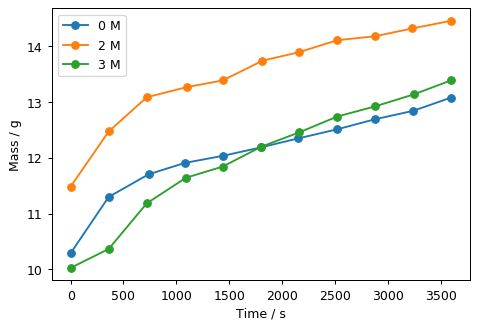

In [1]:
for run, conc in zip(runs, concs):
    plt.plot(*run.T, 'o-', label=conc)
plt.xlabel("Time / s")
plt.ylabel("Mass / g")
plt.legend()

Normalize using mass difference:

normalized mass = (mass\_i - mass\_0) / mass\_i



In [1]:
# normalize the data by the mass at time t=0
for run in runs:
    mass_0 = run[0,1]
    run[0,1] = run[0,1] - mass_0
    run[1:,1] = (run[1:,1] - mass_0) / run[1:,1]

Replot the normalized data.



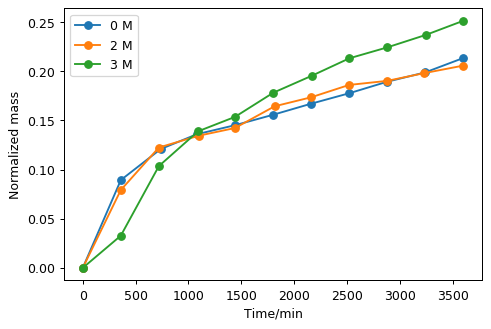

In [1]:
for run, conc in zip(runs, concs):
    plt.plot(*run.T, 'o-', label=conc)
plt.xlabel("Time/min")
plt.ylabel("Normalized mass")
plt.legend()

## Fit 0 M (pure water) hydration to Peleg equation



Peleg model function for curve\_fit.



In [1]:
def peleg(t, k1, k2):
    return t/(k1 + k2*t)

In [1]:
time, mass_norm = M0.T
time = time/60  # minutes
popt, pcov = curve_fit(peleg, time, mass_norm)

# residuals
resids = mass_norm - peleg(time, *popt)
ssr = np.sum(resids**2)
perr = np.sqrt(np.diag(pcov))
print(popt,ssr)

[55.14101663  4.16015576] 0.0008694758909539596

Plot data to examine quality of fit.



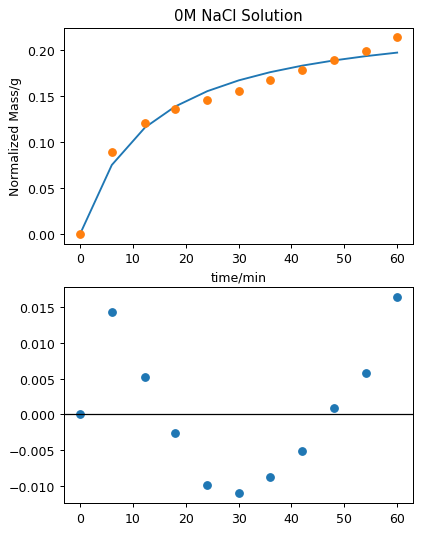

In [1]:
k1, k2 = popt

fig = plt.figure(figsize=(5,7))
plt.subplot(211)
plt.plot(time, peleg(time, k1, k2))
plt.plot(time, mass_norm, 'o')
plt.xlabel("time/min"); plt.ylabel("Normalized Mass/g")
plt.title("0M NaCl Solution")
plt.subplot(212)
plt.plot(time, resids, 'o')
plt.axhline(0, lw=1, color='k')

Looks like there is &ldquo;structure&rdquo; to the residuals in the region where both mechanisms contribute substantially to the water uptake.  The Peleg equation is empirical.

curve\_fit optimizes the fit without passing initial guesses for k<sub>1</sub>, k<sub>2</sub>. However, because students are asked to estimate where k\_1 and k\_2 dominate in the limits of short and long times (see questions 18&#x2013;20), it may be instructive to have them supply the initial guesses.  If so, add the &ldquo;p0&rdquo; argument to curve\_fit (initial guess parameters).



In [1]:
guess = [50, 2] # initial guesses for k1, k2
popt, pcov = curve_fit(peleg, time, mass_norm, guess)
popt

array([55.14119325,  4.16015058])

## Fitting Handbook Data for 1M and 2M



In [1]:
results = []
concs = ["0 M", "1 M", "2 M"]
for run, conc in zip(runs, concs):
    time, mass = run.T
    time = time/60
    popt, pcov = curve_fit(peleg, time, mass)
    ssr = np.sum((mass_norm - peleg(time, *popt))**2)
    results.append([conc, *popt, ssr])
results

| 0 M | 55.141016631758696 | 4.160155760657956 | 0.0008694758909539596 |
| 1 M | 57.537505008633275 | 4.060291142751115 | 0.0009207373631848034 |
| 2 M |  97.22218428348668 | 2.390428180329199 |  0.008942522244720768 |

## Polynomial fit



Try a polynomial model function.  In essence, this minimizes the squared error

$$ E = \sum_{j=0}^{k} |p(x_j) - y_{j}|^2 $$

Define a second order polynomial function and call `curve_fit()` with this function.  It&rsquo;s common practice to pass coefficients as a list-like object.



In [1]:
def poly2(t, a, b, c):
    "Second order polynomial with coefficients from list a"
    return a*t**2 + b*t + c

popt, pcov = curve_fit(poly2, time, mass_norm)
perr = np.sqrt(np.diag(pcov))
perr

array([1.81080117e-05, 1.12874319e-03, 1.45736117e-02])

Text(0.5, 1.0, 'err = 1.8e-05  1.1e-03  1.5e-02')

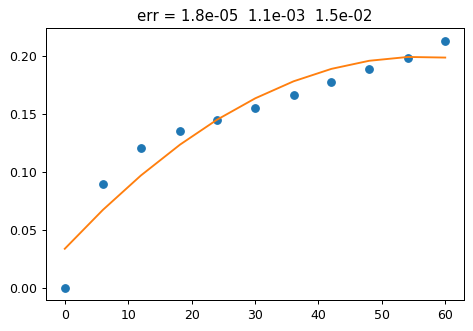

In [1]:
plt.plot(time, mass_norm, 'o')
plt.plot(time, poly2(time, *popt))

plt.title(f"err = {perr[0]:.1e}  {perr[1]:.1e}  {perr[2]:.1e}")

## Handbook data from TATD Part 2



Later in the handbook, there are tables with data different than the initial table presented. This section repeats the analysis with these data.



In [1]:
fn = "chickpea-hbdata2.csv"
data = np.genfromtxt(fn, skip_header=2, delimiter=",")

Uncomment and run the next two cells if using Colab.  Otherwise skip these two cells.



In [1]:
# run this cell only if using colab
#from google.colab import files
#import io
#fn = "chickpea-hbdata2.csv"
#ul = files.upload()

In [1]:
# run this cell only if using colab
#data = np.genfromtxt(io.BytesIO(ul[fn]), skip_header=2, delimiter=",")

In [1]:
# M1a = 1M from second data set
M1a = data[data[:,0] == 1][:,1:]
M3 = data[data[:,0] == 3][:,1:]
runs = [M1a, M3]
concs = ["1 Ma", "3 M"]

# normalize the data by the mass at time t=0
for run in runs:
    mass_0 = run[0,1]
    run[0,1] = run[0,1] - mass_0
    run[1:,1] = (run[1:,1] - mass_0) / run[1:,1]

In [1]:
time, mass_norm = M1a.T
popt, pcov = curve_fit(peleg, time, mass_norm)

for run, conc in zip(runs, concs):
    time, mass = run.T
    popt, pcov = curve_fit(peleg, time, mass)
    ssr = np.sum((mass_norm - peleg(time, *popt))**2)
    results.append([conc, *popt, ssr])
results

[['0 M', 55.141016631758696, 4.160155760657956, 0.0008694758909539596],
 ['1 M', 57.537505008633275, 4.060291142751115, 0.0009207373631848034],
 ['2 M', 97.22218428348668, 2.390428180329199, 0.008942522244720768],
 ['1 Ma', 52.11538685064912, 3.073760577460154, 0.0011981759819282042],
 ['3 M', 66.10808686646367, 3.1063061715270575, 0.004588992948274206]]